Done.


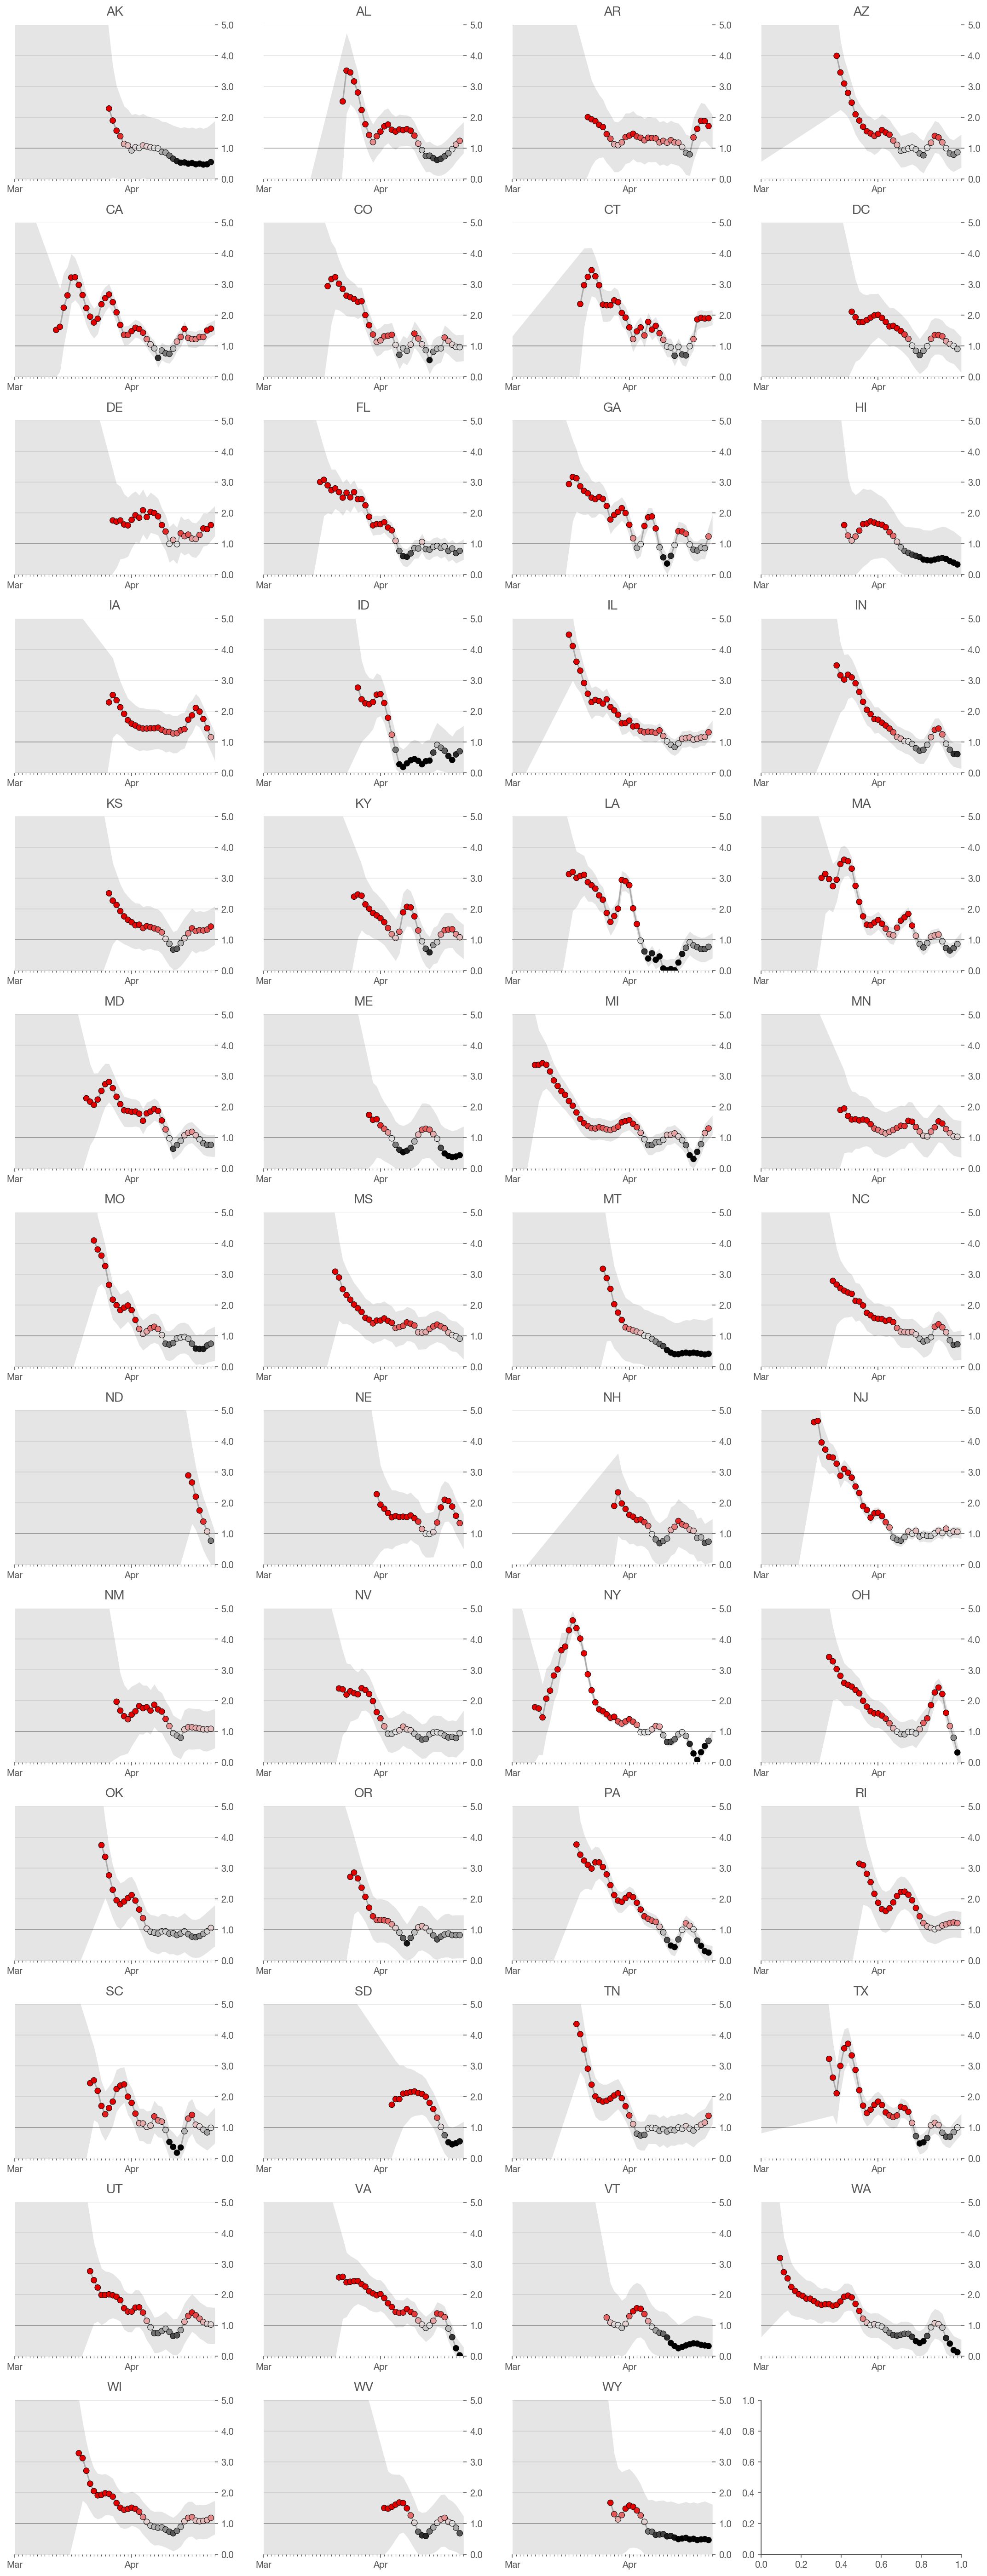

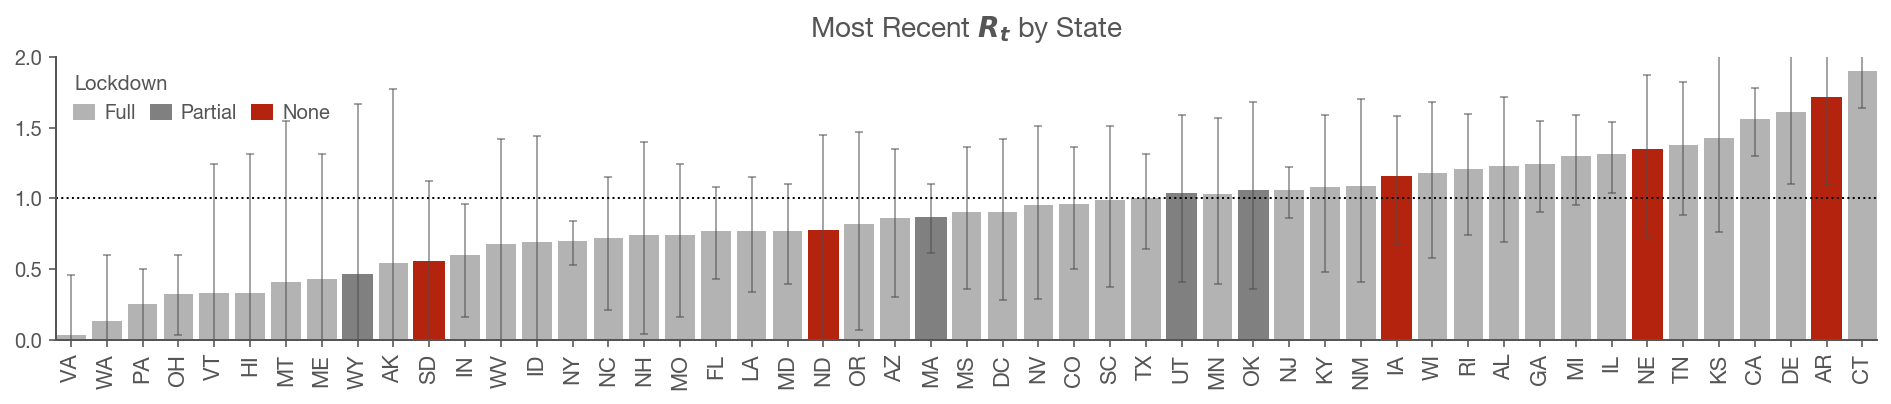

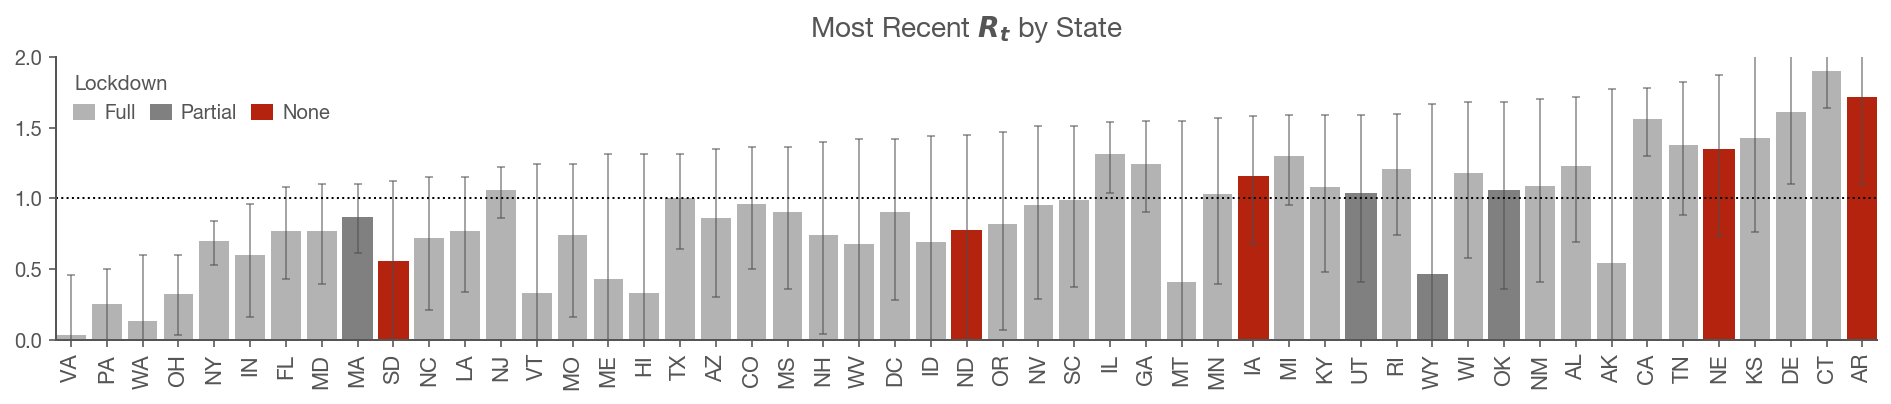

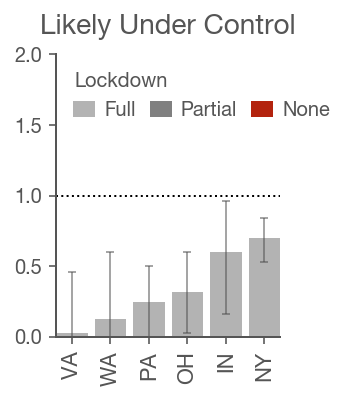

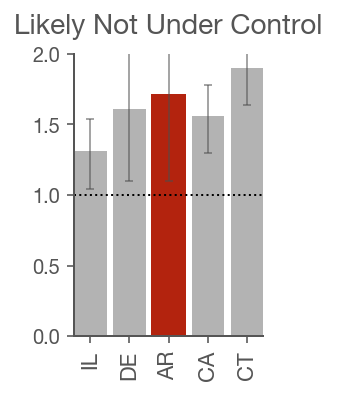

In [28]:
%run 'Realtime R0.ipynb'
#import import_ipynb
#import RealtimeR0

In [29]:
import requests
url = 'https://api.covid19api.com/total/dayone/country/za'
client = requests.request("GET", url)
response = client.text
data_all = pd.read_json(response, orient='columns',convert_dates=['Date'])
data_index = data_all.set_index('Date')
country = data_index['Confirmed']

state_name = 'ZA'

country

Date
2020-03-05 00:00:00+00:00       1
2020-03-06 00:00:00+00:00       1
2020-03-07 00:00:00+00:00       1
2020-03-08 00:00:00+00:00       3
2020-03-09 00:00:00+00:00       3
2020-03-10 00:00:00+00:00       7
2020-03-11 00:00:00+00:00      13
2020-03-12 00:00:00+00:00      17
2020-03-13 00:00:00+00:00      24
2020-03-14 00:00:00+00:00      38
2020-03-15 00:00:00+00:00      51
2020-03-16 00:00:00+00:00      62
2020-03-17 00:00:00+00:00      62
2020-03-18 00:00:00+00:00     116
2020-03-19 00:00:00+00:00     150
2020-03-20 00:00:00+00:00     202
2020-03-21 00:00:00+00:00     240
2020-03-22 00:00:00+00:00     274
2020-03-23 00:00:00+00:00     402
2020-03-24 00:00:00+00:00     554
2020-03-25 00:00:00+00:00     709
2020-03-26 00:00:00+00:00     927
2020-03-27 00:00:00+00:00    1170
2020-03-28 00:00:00+00:00    1187
2020-03-29 00:00:00+00:00    1280
2020-03-30 00:00:00+00:00    1326
2020-03-31 00:00:00+00:00    1353
2020-04-01 00:00:00+00:00    1380
2020-04-02 00:00:00+00:00    1462
2020-04-0

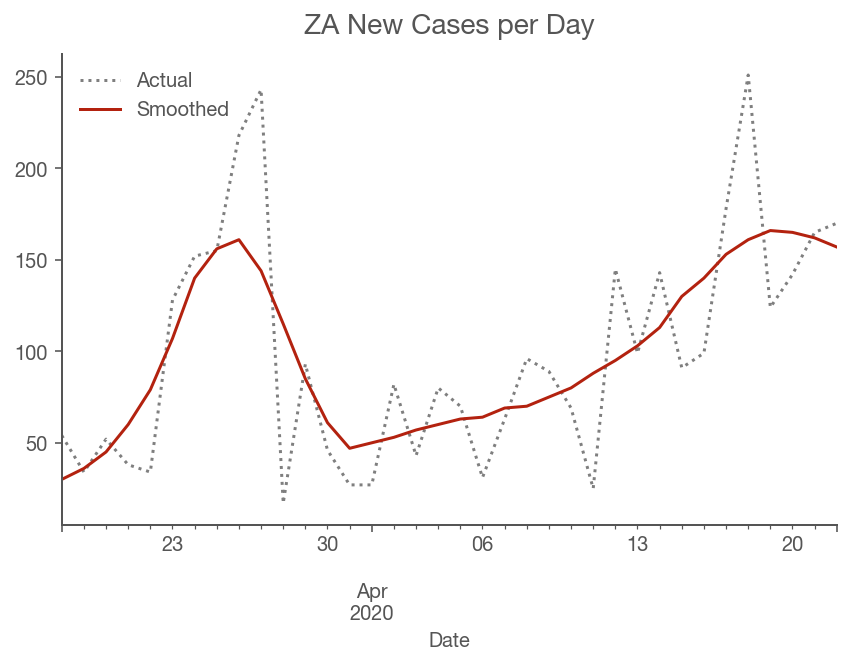

In [30]:
original, smoothed = prepare_cases(country)

original.plot(title=f"{state_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(500/72, 300/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)

ax.get_figure().set_facecolor('w')

In [31]:
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)

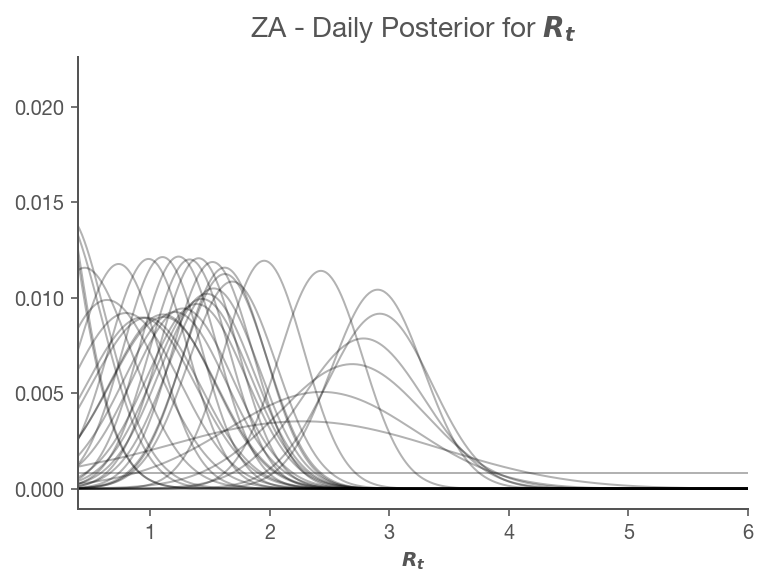

In [32]:
ax = posteriors.plot(title=f'{state_name} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,6))

ax.set_xlabel('$R_t$');

In [33]:
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result

,ML,Low_90,High_90
Date,,,
2020-03-18 00:00:00+00:00,0.00,0.00,10.81
2020-03-19 00:00:00+00:00,2.28,0.36,3.88
2020-03-20 00:00:00+00:00,2.43,1.06,3.65
2020-03-21 00:00:00+00:00,2.69,1.60,3.62
2020-03-22 00:00:00+00:00,2.78,1.91,3.58
2020-03-23 00:00:00+00:00,2.92,2.14,3.58
2020-03-24 00:00:00+00:00,2.90,2.25,3.51
2020-03-25 00:00:00+00:00,2.43,1.84,2.99
2020-03-26 00:00:00+00:00,1.95,1.38,2.48


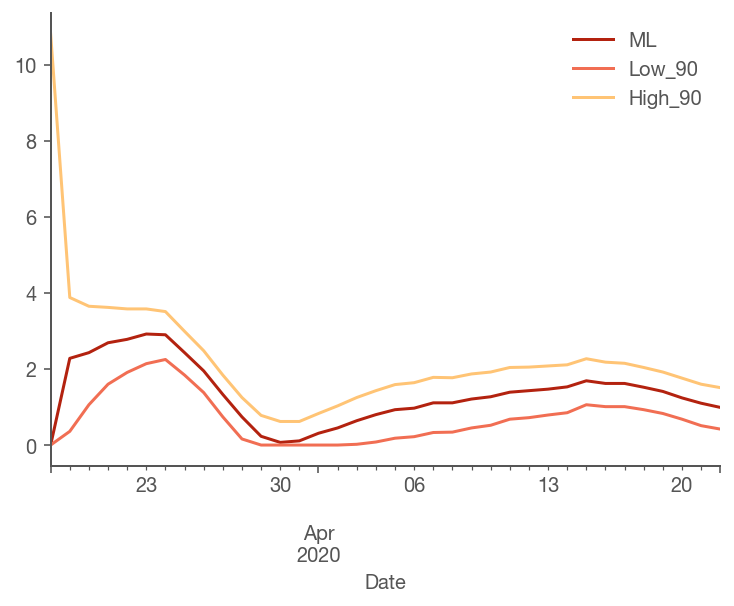

In [34]:
result.plot()